In [85]:
import pandas as pd

In [87]:
import pandas as pd

# Load both datasets
diag_events = pd.read_csv("diagnoses_icd.csv")        # columns: subject_id, hadm_id, seq_num, icd_code, icd_version
icd_dict = pd.read_csv("d_icd_diagnoses.csv")         # columns: icd_code, icd_version, long_title



In [88]:

# Normalize codes to handle leading zeros (so '135' == '0135')
diag_events['icd_code_norm'] = diag_events['icd_code'].astype(str).str.lstrip('0')
icd_dict['icd_code_norm'] = icd_dict['icd_code'].astype(str).str.lstrip('0')



In [91]:
# Keep only dictionary rows where icd_code appears in diagnoses_icd.csv
subset_icd = icd_dict[icd_dict['icd_code_norm'].isin(diag_events['icd_code_norm'])]

# Optional: drop the helper column
subset_icd = subset_icd.drop(columns=['icd_code_norm'])

# Save the subset for Neo4j import
subset_icd.to_csv("subset_d_icd_diagnoses.csv", index=False)
print(f"{len(subset_icd)} ICD codes retained")

29049 ICD codes retained


In [93]:
diag_events['icd_code'].nunique()


28562

In [95]:
# Normalize codes
diag_events['icd_code_norm'] = diag_events['icd_code'].astype(str).str.strip().str.lstrip('0')
icd_dict['icd_code_norm'] = icd_dict['icd_code'].astype(str).str.strip().str.lstrip('0')

# Which codes in diagnoses aren't in dictionary
missing_codes = set(diag_events['icd_code_norm']) - set(icd_dict['icd_code_norm'])
print(len(missing_codes), "codes missing from dictionary")
print(list(missing_codes)[:50])  # show first 50


0 codes missing from dictionary
[]


In [97]:
# Before normalization
n_raw = diag_events['icd_code'].nunique()

# After normalization
n_norm = diag_events['icd_code'].astype(str).str.strip().str.lstrip('0').nunique()

print(f"Raw unique ICD codes: {n_raw}")
print(f"Normalized unique ICD codes: {n_norm}")


Raw unique ICD codes: 28562
Normalized unique ICD codes: 28482


In [99]:
import pandas as pd
df = pd.read_csv("diagnoses_icd.csv")
df[df["icd_code"] == "V1302"]


,subject_id,hadm_id,seq_num,icd_code,icd_version
3013,10003502,21671572,15,V1302,9
5504,10007174,20280072,29,V1302,9
12966,10019517,27896418,15,V1302,9
24455,10037928,23721604,21,V1302,9
24593,10037928,29802992,26,V1302,9
...,...,...,...,...,...
6349448,19978119,24233127,22,V1302,9
6351706,19981610,20359638,4,V1302,9
6355831,19987152,21229906,9,V1302,9
6358532,19991805,23646288,25,V1302,9


In [3]:
diag

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
6364483,19999987,23865745,7,41401,9
6364484,19999987,23865745,8,78039,9
6364485,19999987,23865745,9,0413,9
6364486,19999987,23865745,10,36846,9


In [39]:
import pandas as pd

# -----------------------------
# 1) Load source files (MIMIC-IV)
# -----------------------------
patients = pd.read_csv("patiens.csv")
admissions = pd.read_csv("admissions.csv")

# -----------------------------
# 2) Keep only the columns we need
#    (and only those that actually exist in your admissions file)
# -----------------------------
patients_keep = ["subject_id", "gender", "anchor_age"]

admissions_keep_requested = [
    "subject_id",
    "hadm_id",
    "admittime",
    "dischtime",
    "deathtime",
    "admission_type",
    "admit_provider_id",
    "admission_location",
    "discharge_location",
    "edregtime",
    "edouttime",
    "hospital_expire_flag",
    "insurance",
    "language",
    "marital_status",
    "race",
]

admissions_keep = [c for c in admissions_keep_requested if c in admissions.columns]

patients = patients[patients_keep]
admissions = admissions[admissions_keep]

# -----------------------------
# 3) Merge admissions + patients
#    (one admission row => patient info attached)
# -----------------------------
merged = admissions.merge(patients, on="subject_id", how="left")

# Save merged file (optional, but useful for debugging)
merged.to_csv("merged_admissions_patients.csv", index=False)
print("✅ Saved merged_admissions_patients.csv with", len(merged), "rows")
print("Columns in merged:", merged.columns.tolist())

# -----------------------------
# 4) Build Patient nodes file (1 row per patient)
#    Choose patient-level columns:
#    - gender, anchor_age from patients
#    - insurance/language/marital_status/race are admission-level in MIMIC,
#      so we take the FIRST non-null value per patient (simple approach).
# -----------------------------
patient_cols_requested = [
    "subject_id",
    "gender",
    "anchor_age",
    "insurance",
    "language",
    "marital_status",
    "race",
    "hospital_expire_flag",
]

patient_cols = [c for c in patient_cols_requested if c in merged.columns]

# sort so "first" is consistent (earliest admission first if time exists)
sort_cols = [c for c in ["subject_id", "admittime"] if c in merged.columns]
if sort_cols:
    merged = merged.sort_values(sort_cols)

patients_clean = (
    merged[patient_cols]
    .drop_duplicates(subset="subject_id", keep="first")
    .copy()
)

# -----------------------------
# 5) Rename columns for Neo4j admin import
# -----------------------------
rename_map = {"subject_id": "subject_id:ID(Patient)"}

if "anchor_age" in patients_clean.columns:
    rename_map["anchor_age"] = "anchor_age:int"

if "hospital_expire_flag" in patients_clean.columns:
    rename_map["hospital_expire_flag"] = "hospital_expire_flag:int"

patients_clean = patients_clean.rename(columns=rename_map)

# -----------------------------
# 6) Save Patient nodes CSV
# -----------------------------
patients_clean.to_csv("patients_clean.csv", index=False)
print("✅ Created patients_clean.csv with", len(patients_clean), "patients")

✅ Saved merged_admissions_patients.csv with 4189176 rows
Columns in merged: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'edregtime', 'edouttime', 'hospital_expire_flag', 'gender', 'anchor_age']
✅ Created patients_clean.csv with 223452 patients


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load a sample to keep it fast (MIMIC files are huge)
# Using 100,000 rows to get a representative look
df_pharm = pd.read_csv('pharmacy.csv', low_memory=False, nrows=100000)
df_presc = pd.read_csv('prescriptions.csv', low_memory=False, nrows=100000)

# 2. Check for missingness (Your "Blank" question)
missing_ndc = df_presc['ndc'].isna().sum()
total_rows = len(df_presc)
print(f"Missing NDC codes: {missing_ndc} out of {total_rows} ({missing_ndc/total_rows:.2%})")

# 3. Visualize the top 20 medications
plt.figure(figsize=(10, 6))
df_pharm['medication'].value_counts().head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Administered Medications')
plt.xlabel('Frequency')
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


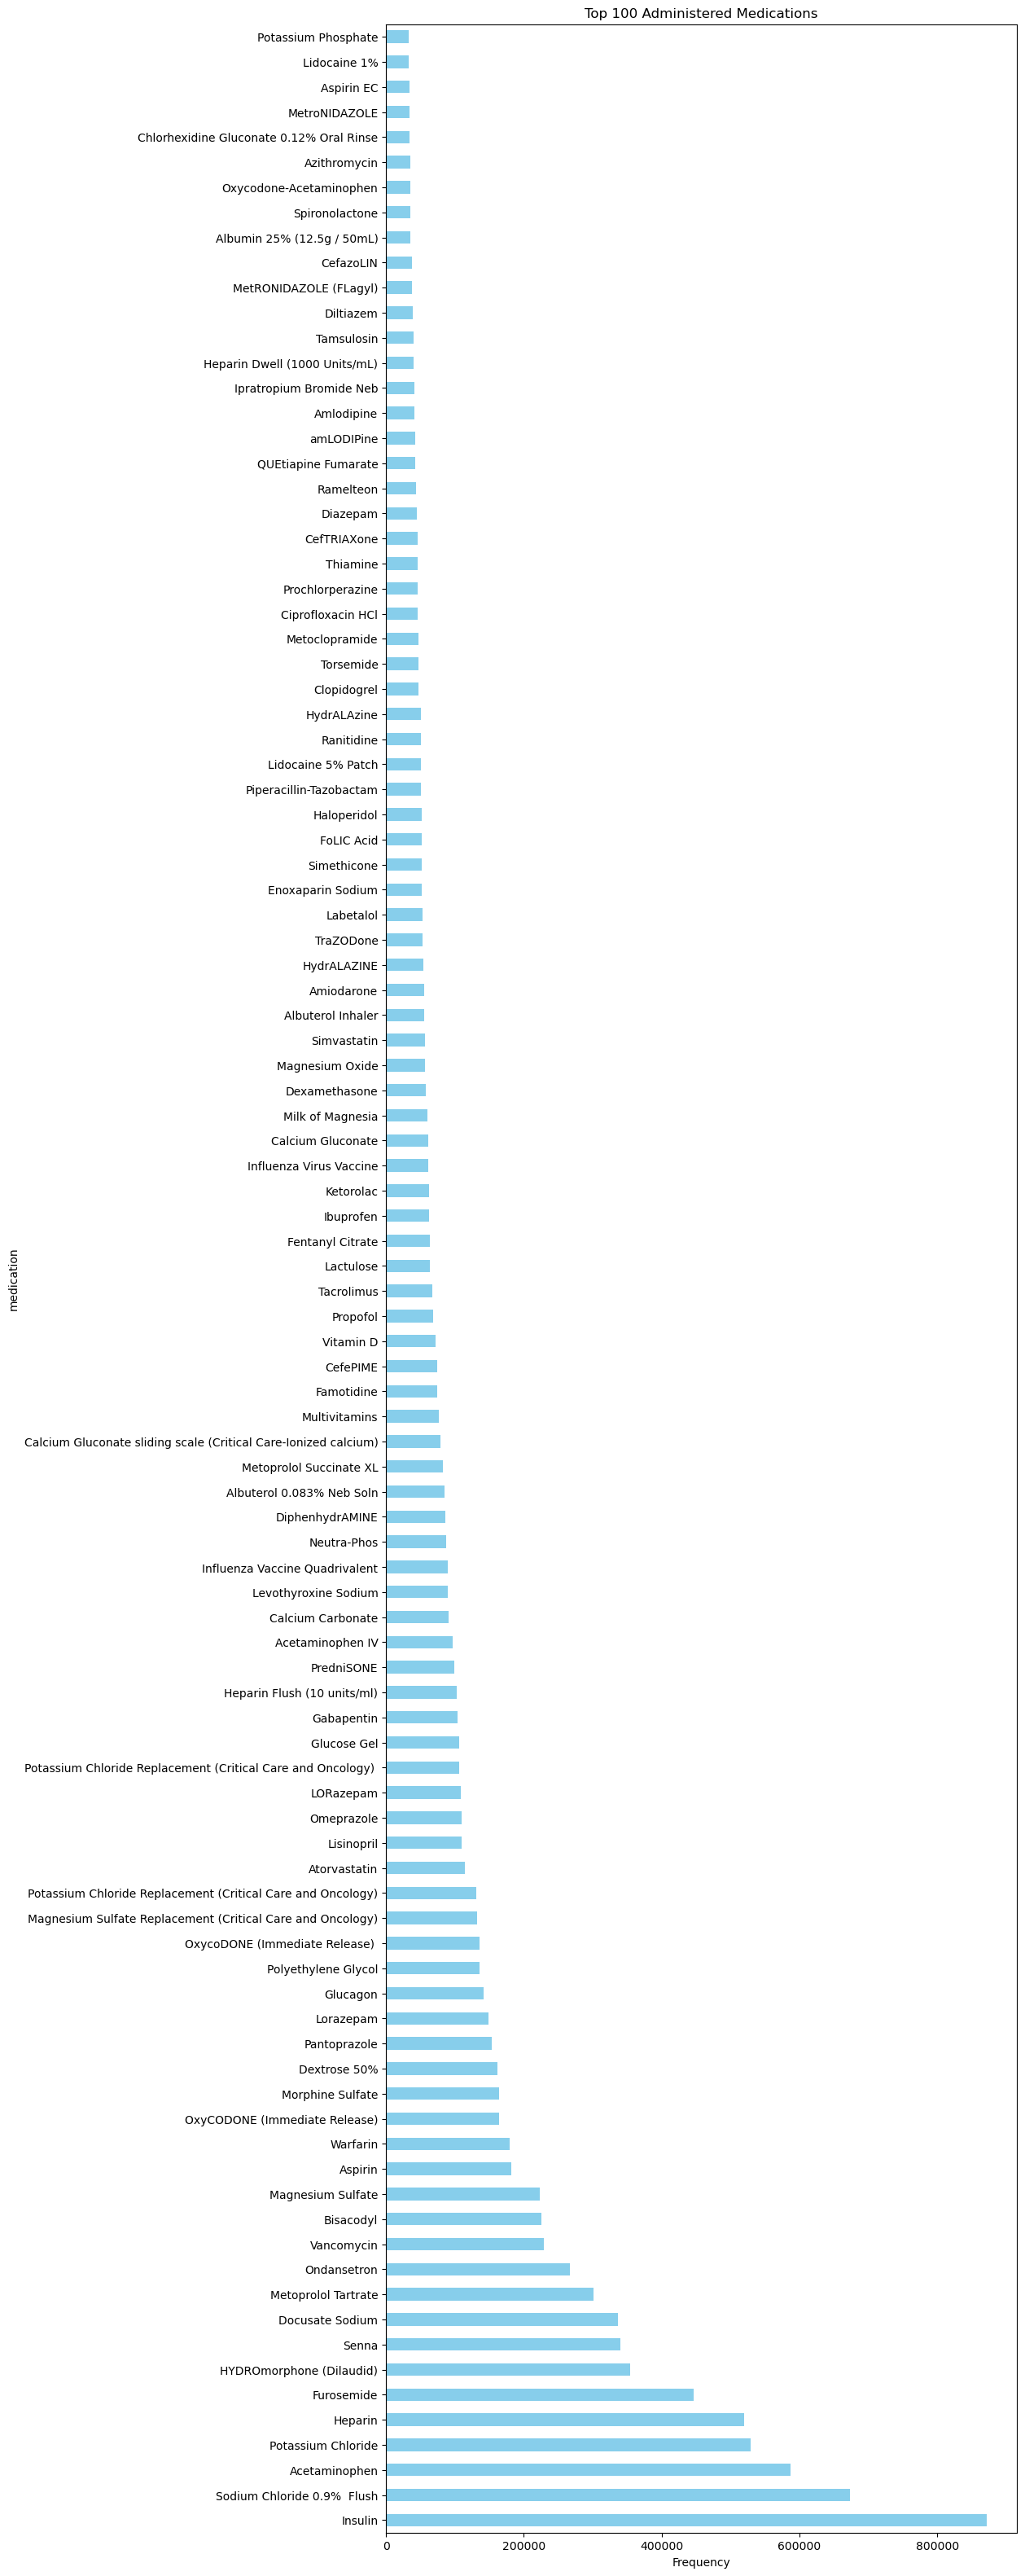

In [13]:
# 3. Visualize the top 20 medications
plt.figure(figsize=(10, 40))
df['medication'].value_counts().head(100).plot(kind='barh', color='skyblue')
plt.title('Top 100 Administered Medications')
plt.xlabel('Frequency')
plt.show()

In [15]:
# Check what percentage of each column is missing
null_counts = df.isnull().mean() * 100
print("Percentage of missing values per column:")
print(null_counts[null_counts > 0].sort_values(ascending=False))

Percentage of missing values per column:
fill_quantity        99.878129
expirationdate       99.878123
one_hr_max           99.652754
lockout_interval     98.283693
basal_rate           98.280572
infusion_type        93.209254
sliding_scale        89.451728
duration             75.862508
disp_sched           40.189046
doses_per_24_hrs     38.575123
expiration_value     12.682530
medication            6.373832
poe_id                0.815781
expiration_unit       0.570593
duration_interval     0.540914
frequency             0.539138
stoptime              0.516423
dispensation          0.444077
route                 0.419559
starttime             0.122672
verifiedtime          0.036817
dtype: float64


In [17]:
df.columns

Index(['subject_id', 'hadm_id', 'pharmacy_id', 'poe_id', 'starttime',
       'stoptime', 'medication', 'proc_type', 'status', 'entertime',
       'verifiedtime', 'route', 'frequency', 'disp_sched', 'infusion_type',
       'sliding_scale', 'lockout_interval', 'basal_rate', 'one_hr_max',
       'doses_per_24_hrs', 'duration', 'duration_interval', 'expiration_value',
       'expiration_unit', 'expirationdate', 'dispensation', 'fill_quantity'],
      dtype='object')

In [25]:
pd.set_option('display.max_columns', None)

In [27]:
df.head()

,subject_id,hadm_id,pharmacy_id,poe_id,starttime,stoptime,medication,proc_type,status,entertime,verifiedtime,route,frequency,disp_sched,infusion_type,sliding_scale,lockout_interval,basal_rate,one_hr_max,doses_per_24_hrs,duration,duration_interval,expiration_value,expiration_unit,expirationdate,dispensation,fill_quantity
0,10000032,22595853,12775705,10000032-55,2180-05-08 08:00:00,2180-05-07 22:00:00,Furosemide,Unit Dose,Discontinued via patient discharge,2180-05-07 09:32:35,2180-05-07 09:32:35,PO/NG,DAILY,08,NaN,NaN,NaN,NaN,NaN,1.0,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN
1,10000032,22595853,18415984,10000032-42,2180-05-07 02:00:00,2180-05-07 22:00:00,Ipratropium Bromide Neb,Unit Dose,Discontinued via patient discharge,2180-05-07 01:49:23,2180-05-07 01:49:23,IH,Q6H,"2, 8, 14, 20",NaN,NaN,NaN,NaN,NaN,4.0,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN
2,10000032,22595853,23637373,10000032-35,2180-05-07 01:00:00,2180-05-07 09:00:00,Furosemide,Unit Dose,Inactive (Due to a change order),2180-05-07 00:09:24,2180-05-07 00:09:24,PO/NG,DAILY,08,NaN,NaN,NaN,NaN,NaN,1.0,NaN,Ongoing,36.0,Hours,NaN,Omnicell,NaN
3,10000032,22595853,26862314,10000032-41,2180-05-07 01:00:00,2180-05-07 01:00:00,Potassium Chloride,Unit Dose,Discontinued,2180-05-07 00:09:24,2180-05-07 00:09:24,PO,ONCE,1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,Doses,36.0,Hours,NaN,Omnicell,NaN
4,10000032,22595853,30740602,10000032-27,2180-05-07 00:00:00,2180-05-07 22:00:00,Sodium Chloride 0.9% Flush,Unit Dose,Discontinued via patient discharge,2180-05-07 00:00:54,2180-05-07 00:00:54,IV,Q8H,"0, 8, 16",NaN,NaN,NaN,NaN,NaN,3.0,NaN,Ongoing,36.0,Hours,NaN,Floor Stock Item,NaN


In [21]:
df_presc = pd.read_csv('prescriptions.csv', low_memory=False, nrows=100000)


In [ ]:
import pandas as pd

# 1. Load Pharmacy (You already have this, but keep only what you need)
# Assuming 'df_pharm' is your pharmacy dataframe
cols_to_keep = ['subject_id', 'pharmacy_id', 'medication', 'route']
df_pharm_slim = df[cols_to_keep]

# 2. Load Prescriptions (ONLY the link and the NDC)
# This prevents your computer from slowing down
df_presc = pd.read_csv('prescriptions.csv', usecols=['pharmacy_id', 'ndc'], low_memory=False)

# 3. Perform the Merge
# 'left' keeps all your pharmacy records and adds NDCs where they exist
df_merged = pd.merge(df_pharm_slim, df_presc, on='pharmacy_id', how='left')

# 4. Audit the result
print(f"Total rows: {len(df_merged)}")
print(f"Rows with NDC: {df_merged['ndc'].notna().sum()}")